# Test out loading cm-rep meshes and performing shooting

In [2]:
%matplotlib inline
import gshoot
import numpy as np
import torch
import seaborn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import vtk_io
import scipy.optimize as opt
import scipy.linalg as la

In [60]:
# Read the template array
temp=vtk_io.read_bcmrep('./testdata/placenta/placenta_template_anterioralign3_bcmrep.vtk')

<IPython.core.display.Javascript object>


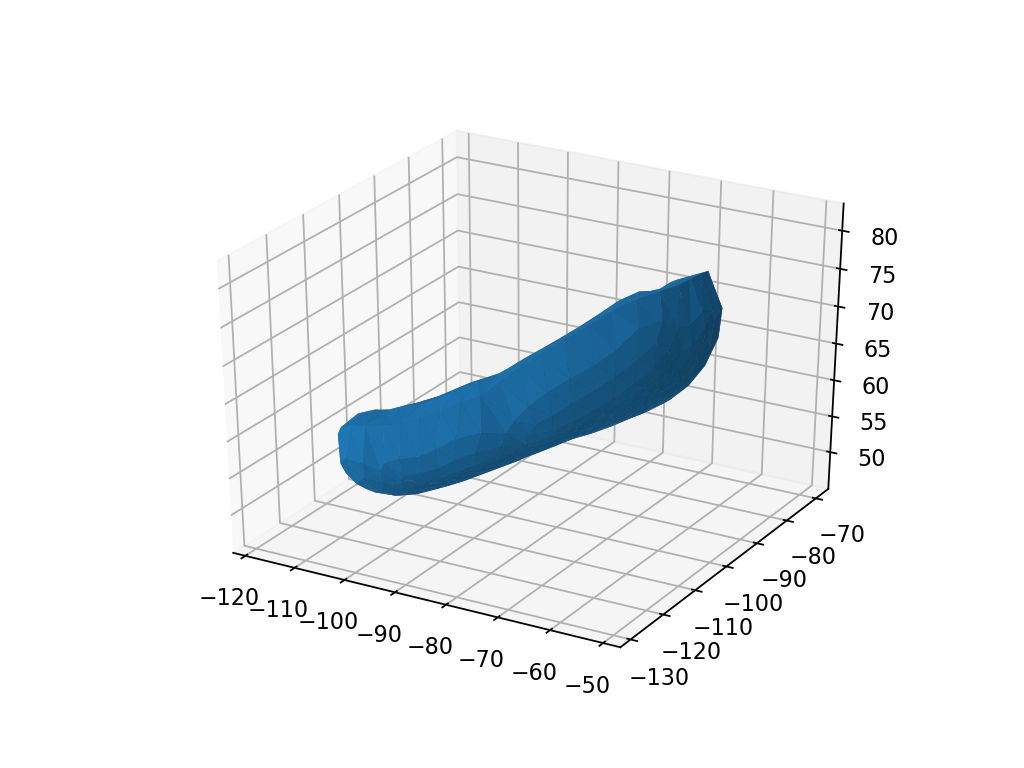

In [61]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(temp.X[:,0],temp.X[:,1],temp.X[:,2],triangles=temp.T)
fig.show()

In [19]:
# Load the target mesh
targ=vtk_io.read_bcmrep('./testdata/placenta/ac_deform_init_bcmrep.vtk')

In [46]:
def shape_procrustes(X,Y):
    X0=X-np.mean(X,axis=0)
    Y0=Y-np.mean(Y,axis=0)
    R,scale=la.orthogonal_procrustes(Y0, X0)
    return np.dot(Y0,R)+np.mean(X,axis=0)

<IPython.core.display.Javascript object>


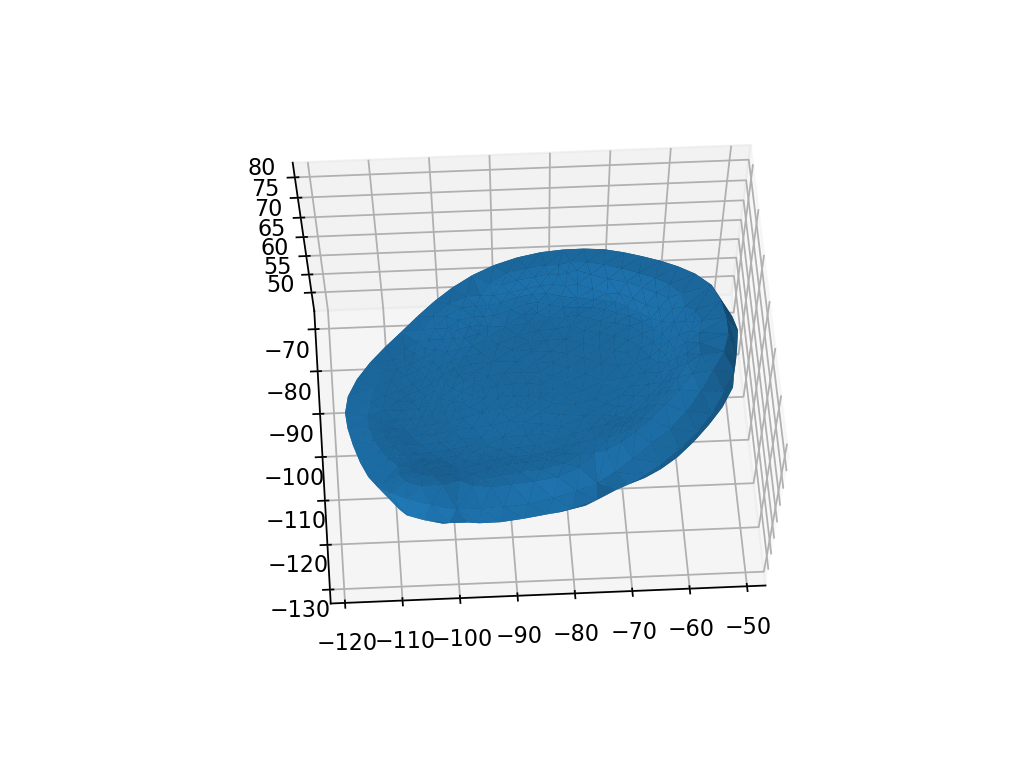

In [51]:
targp=targ;
targp.X = shape_procrustes(temp.X,targ.X)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(temp.X[:,0],temp.X[:,1],temp.X[:,2],triangles=temp.T)
# ax.plot_trisurf(targp.X[:,0],targp.X[:,1],targp.X[:,2],triangles=targp.T)
fig.show()

Create some pytorch tensors from the mesh

In [4]:
X=torch.FloatTensor(temp.X)
T=torch.LongTensor(temp.T)
MI=torch.LongTensor(temp.MI)
triMI=torch.LongTensor(temp.triMI)

## Define a medialness objective function

Define the objective function for the medial center point $Y$ as the variance of distance between triangle vertices $X_i$ and $Y$. Try minimizing this objective function

In [8]:
class MedialTriangleAllPairsObjective:
    def __init__(self, X, T, triMI):
        self.X = Variable(X, requires_grad=False)
        self.idx = T[triMI.sort()[1]].view(-1,6)
        self.Y = None
        self.cb_iter = 1
        self.cb_lastval = None
    
    def fun(self,raw_Y):
        self.Y = Variable(torch.FloatTensor(raw_Y),requires_grad=True)
        dist = torch.norm(self.X[self.idx.view(-1),:].view(-1,6,3) - self.Y.view(-1,1,3),2,dim=2)
        self.res = torch.sum(torch.var(dist,dim=1))
        return self.res.data.numpy()[0]
    
    def grad(self,raw_Y):
        # if self.Y is None or not np.array_equal(self.Y.data.numpy(), raw_Y):
        self.fun(raw_Y)
        self.res.backward()
        return self.Y.grad.data.numpy()
    
    def init(self):
        Y0=torch.mean(self.X[self.idx.view(-1),:].view(-1,6,3),1)
        return Y0.data.view(-1).numpy()
    
    def callback(self, raw_Y):
        val = self.fun(raw_Y)
        if self.cb_lastval is None or val < 0.99 * self.cb_lastval:
            print('Iter: %4i   f: %8.6f' % (self.cb_iter, val))
            self.cb_lastval = val
        self.cb_iter = self.cb_iter + 1
    
    

In [9]:
# Create an optimization problem and initialize it
prob = MedialTriangleAllPairsObjective(X,T,triMI)
y0 = prob.init()

In [10]:
# Perform optimization
opt_options={'maxiter':200,'disp':True}
res=opt.minimize(
    lambda x:prob.fun(x),y0,method='CG',jac=lambda x:prob.grad(x),
    options=opt_options,callback=lambda x:prob.callback(x))

Iter:    1   f: 48.997665
Iter:    2   f: 19.480175
Iter:    3   f: 8.481991
Iter:    4   f: 5.427365
Iter:    5   f: 3.167630
Iter:    6   f: 1.495107
Iter:    7   f: 1.113740
Iter:    8   f: 0.932994
Iter:    9   f: 0.774293
Iter:   10   f: 0.615233
Iter:   11   f: 0.579053
Iter:   12   f: 0.558241
Iter:   13   f: 0.548406
Iter:   14   f: 0.533281
Iter:   15   f: 0.523326
Iter:   17   f: 0.516891
         Current function value: 0.512187
         Iterations: 43
         Function evaluations: 154
         Gradient evaluations: 142


In [14]:
# Get the current medial center points
Y=torch.FloatTensor(res.x).view(-1,3)

## Define an objective function involving combining geodesic shooting and medialness

Create medial polygons as duals of the boundary triangles

In [15]:
Tmed=MI[T[triMI.sort()[1]].view(-1)].view(-1,6)[:,0:3]
def find_med_cycle(i):
    
    

IndentationError: expected an indented block (<ipython-input-15-6f784bda2f95>, line 4)

In [231]:
q=MI[T[triMI.sort()[1]].view(-1)].view(-1,6)[:,0:3]
t116=torch.nonzero(q==116)
v116=q[t116[:,0],:]
blop=v116[v116 != 116].view(-1,2)

In [232]:
vis=blop.size(0)


6

In [301]:
class HalfEdge:
    """ This class creates a half-edge data structure from a set of properly
    winded triangle indices. The class does not take the coordinates of the
    vertices, i.e., it is purely abstract w.r.t. to the coordinates
    
    Internal representation:
    
        self.he       is a M x 2 tensor of (vertex, vertex) pairs
        self.he_tri   is a M x 1 tensor mapping half-edge to its triangle
        self.he_tri_k is a M x 1 tensor mapping half-edge to its triangle index
        self.he_opp   is a M x 1 tensor mapping half-edge to its opposite
        self.tri_he   is a N x 3 tensor mapping triangles to half-edges
    """
   
    # T is a N x 3 LongTensor of vertex indices
    def __init__(self,T):
        
        # List of half-edges and their triangles
        l_he = list()
        l_he_tri = list()
        l_he_opp = list()
        l_tri_he = list()
        l_he_tri_k = list()
        
        # Iterate over all triangles
        for i in range(T.size(0)):
            for k in range(3):
                l_he.append((T[i,k],T[i,(k+1)%3]))
                l_he_tri.append(i)
                l_he_tri_k.append(k)
            l_tri_he.append(range(len(l_he)-3,len(l_he)))
            
        # Compute the opposite of every half-edge
        for j in range(len(l_he)):
            try:
                l_he_opp.append(l_he.index(l_he[j][::-1]))
            except ValueError:
                l_he_opp.append(-1)
        
        self.he = torch.LongTensor(l_he)
        self.he_tri = torch.LongTensor(l_he_tri)
        self.he_tri_k = torch.LongTensor(l_he_tri_k)
        self.he_opp = torch.LongTensor(l_he_opp)
        self.tri_he = torch.LongTensor(l_tri_he)
        
    # Get the index of the next half-edge on the half-edge's triangle
    def next_he(self, j):
        t, k = self.he_tri[j],self.he_tri_k[j]
        return self.tri_he[t, (k+1)%3]
        
    # Compute the dual of a triangulation. Every triangle is a vertex and new
    # faces are generated (non-triangular). Returns a list of faces, each indexing
    # the original triangle array
    def compute_dual(self):
        
        # Each half-edge with an opposite should be visited once
        viz = torch.zeros(self.he_opp.size())
        polys = list()
        for j in range(self.he.size(0)):
            p = list()
            q = list()
            m = j
            while viz[m] == 0 and self.he_opp[m] > -1:
                p.append(self.he_tri[m])
                q.append(self.he[m].numpy())
                viz[m] = 1
                m = self.next_he(self.he_opp[self.next_he(m)])
            if len(p) > 0 and p[0] == self.he_tri[m]:
                polys.append(p)
        return polys
                
                 
                
                
            

In [302]:
H=HalfEdge(T)
dual=H.compute_dual()

[[0, 3, 2, 17, 19, 16],
 [0, 16, 12, 8, 4],
 [0, 4, 7, 6, 1, 3],
 [1, 817, 819, 816, 2, 3],
 [1, 6, 224, 221, 1037, 1042, 820, 817],
 [2, 816, 833, 838, 20, 17],
 [4, 8, 11, 10, 5, 7],
 [5, 225, 227, 224, 6, 7],
 [5, 10, 232, 228, 225],
 [8, 12, 15, 14, 9, 11],
 [9, 233, 235, 232, 10, 11],
 [9, 14, 248, 244, 240, 236, 233],
 [12, 16, 19, 18, 13, 15],
 [13, 249, 251, 248, 14, 15],
 [13, 18, 22, 26, 249],
 [17, 20, 23, 22, 18, 19],
 [20, 838, 839, 837, 21, 23],
 [21, 24, 27, 26, 22, 23],
 [21, 837, 842, 846, 850, 32, 28, 24],
 [24, 28, 31, 30, 25, 27],
 [25, 250, 251, 249, 26, 27],
 [25, 30, 273, 254, 245, 250],
 [28, 32, 35, 34, 29, 31],
 [29, 274, 275, 273, 30, 31],
 [29, 34, 38, 269, 274],
 [32, 850, 851, 849, 33, 35],
 [33, 36, 39, 38, 34, 35],
 [33, 849, 854, 858, 40, 36],
 [36, 40, 43, 42, 37, 39],
 [37, 270, 271, 269, 38, 39],
 [37, 42, 46, 278, 265, 270],
 [40, 858, 859, 857, 41, 43],
 [41, 44, 47, 46, 42, 43],
 [41, 857, 862, 866, 48, 44],
 [44, 48, 51, 50, 45, 47],
 [45, 276, 2

In [296]:
np.unique(H.he.numpy(),axis=0).shape

(4896, 2)

In [223]:
v116=q[torch.nonzero(q==116)[:,0],:]
v116[v116!= 116].view(-1,2)


   0  117
 124    0
   2  115
 122    2
 115  117
 124  122
[torch.LongTensor of size 6x2]

Plot the medial surface

<IPython.core.display.Javascript object>


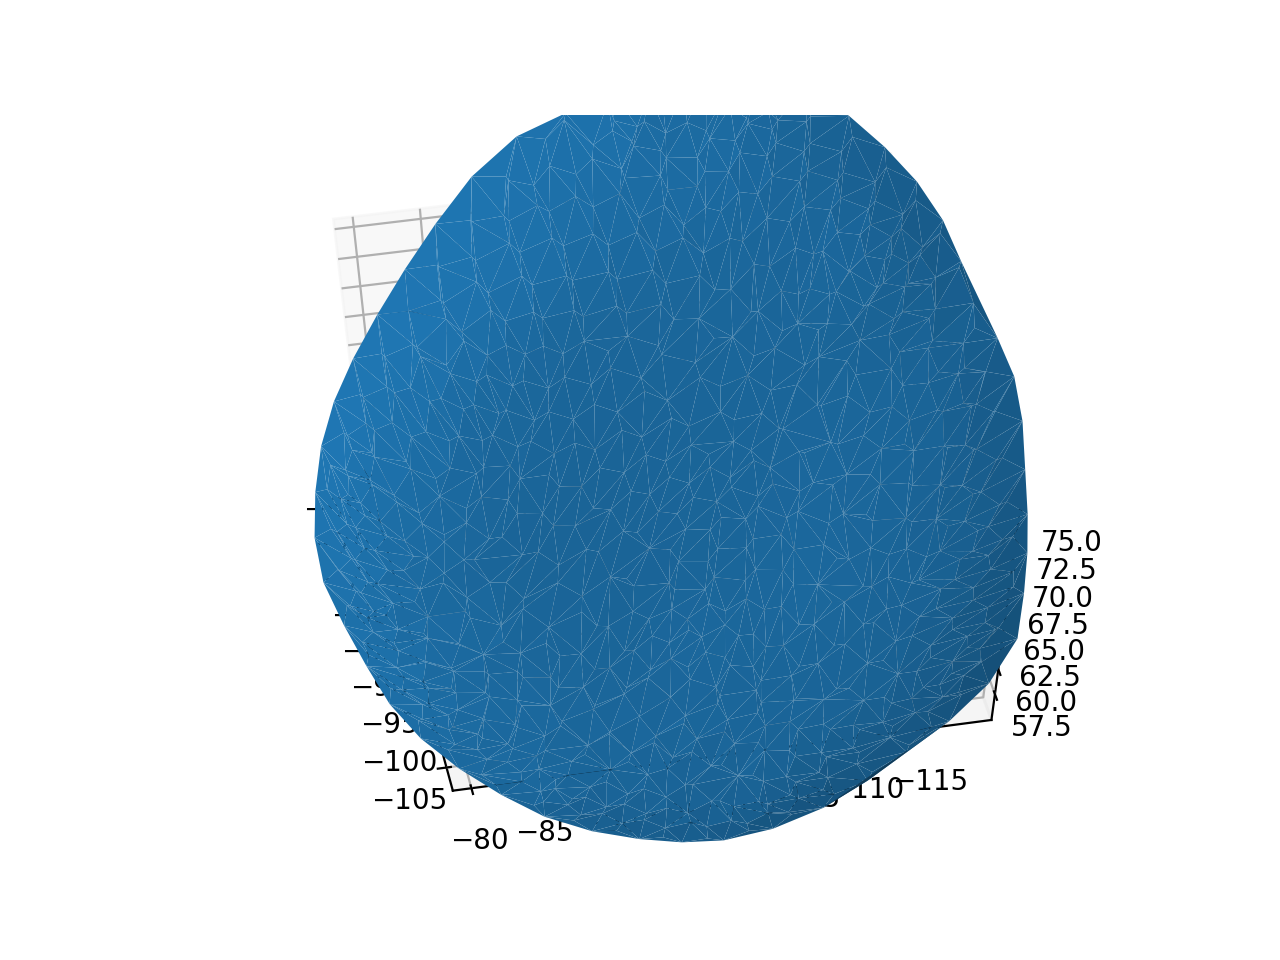

In [203]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.plot_trisurf(X[qidx[0,:]][:,0].numpy(),X[qidx[0,:]][:,1].numpy(),X[qidx[0,:]][:,2].numpy())
ax.plot_trisurf(Y[:,0].numpy(),Y[:,1].numpy(),Y[:,2].numpy())
fig.show()

In [125]:
X[qidx[0,:]][:,0].numpy()

array([-107.80000305, -110.63899994, -108.06700134, -107.76599884,
       -110.63899994, -107.80000305], dtype=float32)